---
We'll use tensorflow to predict the number of shapes in each image.

First let's get the pixel data, saving it as `.npy` files in `greyscale-data`

---

In [7]:
import os
import numpy as np
from PIL import Image


input_directory = 'greyscaled-images'
output_directory = 'greyscaled-data'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in os.listdir(input_directory):
  path = os.path.join(input_directory, filename)
  image = Image.open(path)
  pixel_data = [pixel / 255. for row in np.array(image) for pixel in row]
  output_filename = '%s.npy' % filename.split('.')[0]
  output_path = os.path.join(output_directory, output_filename)
  np.save(output_path, pixel_data)

---
Load data into various structures for later.  This cell mainly splits the data into training, validation and test folds.  To make the splits I'm hashing filenames and then sorting those hashes alphabetically -- this mixes up the images, but makes the mixing deterministic.

---

In [8]:
import hashlib


input_directory = 'greyscaled-data'

# Load all the data into an array.
# Each element is a tuple: (filename, numpy data).
# The filename structure is "<number>-<color>-<texture>-<shape>-<rotation>.png"
all_data = [
  (f, np.load(os.path.join(input_directory, f))) for f in os.listdir(input_directory)
]

# Hash the filename and sort the hashes alphabetically.
all_data_with_hashes = [
  (filename, hashlib.md5(filename).hexdigest(), data) for filename, data in all_data
]
all_data_sorted = sorted(all_data_with_hashes, key=lambda element: element[1])

# Save 20% of the data for testing (the final, one-shot evaluation of performance).
split_index = int(0.2 * len(all_data_sorted))
test_data = all_data_sorted[0:split_index]
remaining_data = all_data_sorted[split_index:]

# Now save 20% of the remaining data for validation.
split_index = int(0.2 * len(remaining_data))
validation_data = remaining_data[0:split_index]
training_data = remaining_data[split_index:]

# For convenience, get all the pixel data into separate arrays.
training_pixel_data = [pixel_data for _, _, pixel_data in training_data]
validation_pixel_data = np.array([pixel_data for _, _, pixel_data in validation_data])
test_pixel_data = np.array([pixel_data for _, _, pixel_data in test_data])

# Each filename, in its text, has an embedded "number of shapes."
# We need to convert those classes (the output ground truth) into label arrays.
all_labels = [
    [1., 0., 0.],
    [0., 1., 0.],
    [0., 0., 1.],
]
training_labels = [
  all_labels[int(filename.split('-')[0]) - 1] for filename, _, _ in training_data
]
validation_labels = [
  all_labels[int(filename.split('-')[0]) - 1] for filename, _, _ in validation_data
]
test_labels = [
  all_labels[int(filename.split('-')[0]) - 1] for filename, _, _ in test_data
]

---
setup tensorflow

---

In [9]:
import random
import tensorflow as tf


learning_rate = 0.005
regularization_factor = 1e-4
card_width, card_height = 150, 150
hidden_layer_size = 1024

graph = tf.Graph()
with graph.as_default():
  # Setup the training steps.
  tf_training_data = tf.placeholder(tf.float32, shape=[None, card_width*card_height])
  tf_training_labels = tf.placeholder(tf.float32, shape=[None, 3])
  
  # Create a single hidden layer of ReLUs.
  hidden_weights = tf.Variable(tf.truncated_normal([card_width*card_height, hidden_layer_size]), name='hidden_weights')
  hidden_biases = tf.Variable(tf.zeros([hidden_layer_size]), name='hidden_biases')
  hidden_layer = tf.nn.relu(tf.matmul(tf_training_data, hidden_weights) + hidden_biases)
  
  # Build the output layer.
  output_weights = tf.Variable(tf.truncated_normal([hidden_layer_size, 3]), name='output_weights')
  output_biases = tf.Variable(tf.zeros([3]), name='output_biases')
  output_logits = tf.matmul(hidden_layer, output_weights) + output_biases
  training_estimate = tf.nn.softmax(output_logits)

  # Calculate loss and setup the optimizer.
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output_logits, tf_training_labels))
  l2_regularization = tf.nn.l2_loss(output_weights) + tf.nn.l2_loss(hidden_weights)
  loss += regularization_factor * l2_regularization
  training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  # Setup validation.  We have to reshape into a "dense tensor"
  # by, essentially, combining this array of arrays into a true matrix.
  tf_validation_pixel_data = tf.constant(
    validation_pixel_data.reshape((-1, card_width*card_height)).astype(np.float32))
  validation_hidden_layer = tf.nn.relu(tf.matmul(tf_validation_pixel_data, hidden_weights) + hidden_biases)
  validation_logits = tf.matmul(validation_hidden_layer, output_weights) + output_biases
  validation_estimate = tf.nn.softmax(validation_logits)

  # Setup the final test run.
  tf_test_pixel_data = tf.constant(
    test_pixel_data.reshape((-1, card_width*card_height)).astype(np.float32))
  test_hidden_layer = tf.nn.relu(tf.matmul(tf_test_pixel_data, hidden_weights) + hidden_biases)
  test_logits = tf.matmul(test_hidden_layer, output_weights) + output_biases
  test_estimate = tf.nn.softmax(test_logits)

---
aside: create a small function to calculate the accuracy of a set of predictions
  
---

In [10]:
def calculate_accuracy(predictions, ground_truth):
  """Determine what proportion of predictions are accurate based on ground truth."""
  correctness = np.sum(np.argmax(predictions, 1) == np.argmax(ground_truth, 1))
  return 100. * correctness / predictions.shape[0]

---
and run the optimizer in batches

---

In [11]:
accuracies = []
total_iterations = 100
batch_size = 100

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  variable_saver = tf.train.Saver()

  for iteration in range(total_iterations):
    batch_data = random.sample(training_data, batch_size)
    batch_input_pixel_data = [pixel_data for _, _, pixel_data in batch_data]
    batch_labels = [
      all_labels[int(filename.split('-')[0]) - 1] for filename, _, _ in batch_data
    ]
    batch_training_data = {
      tf_training_data: batch_input_pixel_data,
      tf_training_labels: batch_labels,
    }
    _, step_loss, training_predictions = session.run(
      [training_step, loss, training_estimate], feed_dict=batch_training_data)
  
    if (iteration % (total_iterations / 20)) == 0:
      training_accuracy = calculate_accuracy(training_predictions, batch_labels)
      validation_accuracy = calculate_accuracy(validation_estimate.eval(), validation_labels)
      accuracies.append((iteration, training_accuracy, validation_accuracy))
      if (iteration % (total_iterations / 10)) == 0:
        print 'iteration: %s -> loss: %s, training accuracy: %0.1f%%, validation accuracy: %0.1f%%' % (
          iteration, step_loss, training_accuracy, validation_accuracy)
  variable_saver.save(session, '/tmp/count-shapes-model.ckpt', latest_filename='count-shapes-checkpoint-list')
  print '\ntest accuracy: %0.1f%%' % calculate_accuracy(test_estimate.eval(), test_labels)

iteration: 0 -> loss: 1956.86, training accuracy: 26.0%, validation accuracy: 46.6%
iteration: 10 -> loss: 3410.82, training accuracy: 26.0%, validation accuracy: 32.0%
iteration: 20 -> loss: 3184.9, training accuracy: 29.0%, validation accuracy: 33.0%
iteration: 30 -> loss: 1643.32, training accuracy: 62.0%, validation accuracy: 46.6%
iteration: 40 -> loss: 1455.85, training accuracy: 46.0%, validation accuracy: 44.7%
iteration: 50 -> loss: 1300.04, training accuracy: 57.0%, validation accuracy: 65.0%
iteration: 60 -> loss: 948.064, training accuracy: 81.0%, validation accuracy: 94.2%
iteration: 70 -> loss: 989.83, training accuracy: 79.0%, validation accuracy: 85.4%
iteration: 80 -> loss: 890.516, training accuracy: 100.0%, validation accuracy: 100.0%
iteration: 90 -> loss: 890.507, training accuracy: 100.0%, validation accuracy: 100.0%

test accuracy: 100.0%


---
plot the accuracy vs iteration number

---

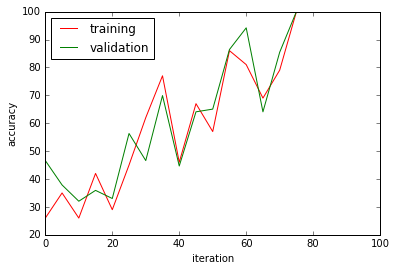

In [12]:
% matplotlib inline
import matplotlib.pyplot as plt


iterations, training_accuracies, validation_accuracies = zip(*accuracies)
plt.plot(iterations, training_accuracies, 'r-', label='training')
plt.plot(iterations, validation_accuracies, 'g-', label='validation')
_ = plt.xlabel('iteration')
_ = plt.ylabel('accuracy')
_ = plt.legend(loc='best')